In [ ]:
from google.colab import files
uploaded = files.upload()

Saving japan_birth.csv to japan_birth.csv


In [ ]:
import io
import pandas as pd
df2 = pd.read_csv(io.BytesIO(uploaded['japan_birth.csv']))

**Question 1:** Considering the "birth_total" column for the data set and providing posterior inference. \
Based on the histograms available on kaggle, the birth_total column's histogram is consistent with a normal distribution, making it suitable for a normal-gamma model.\
for reference: [Japan Birth Statistics](https://www.kaggle.com/datasets/webdevbadger/japan-birth-statistics)

/usr/local/lib/python3.10/dist-packages/pymc/model.py:1363: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


HMC Split-Rhats {'theta': 0.9992, 'phi': 1.0027}


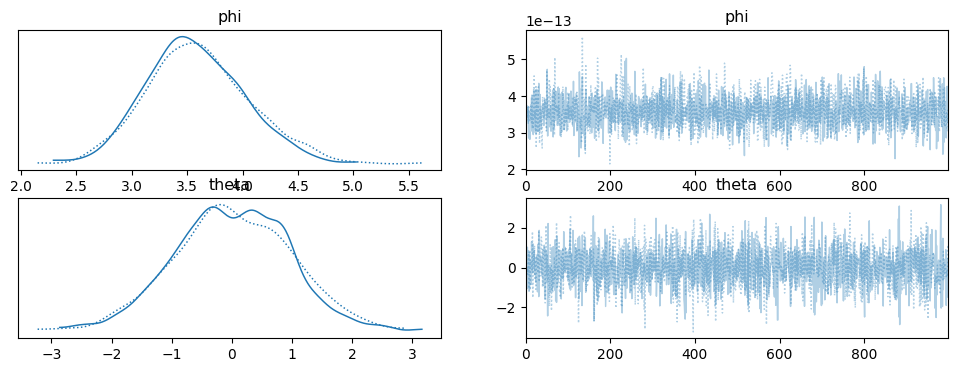

In [ ]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
from scipy.stats import gaussian_kde;

data = df2['birth_total']

normal_gamma_model = pm.Model()
with normal_gamma_model:
    phi = pm.Gamma('phi', alpha=1, beta=1)
    theta = pm.Normal('theta', mu=0, sigma=1)
    obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=data)

with normal_gamma_model:
    idata_HMC = pm.sample()

az.plot_trace(idata_HMC, var_names=['phi', 'theta'])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items() if 'phi' in k or 'theta' in k})


**Question 2**: Find a different column of data for which a normal-gamma specification isn't justified. \
The normal-gamma distribution is often appropriate for continuous, normally distributed data. \
Consider the "total_fertility" column in the data set, which is the average number of children that are born to a woman over her lifetime. From the histogram below, the data shows a right skewness, indicating that a normal-gamma specification is not justified.

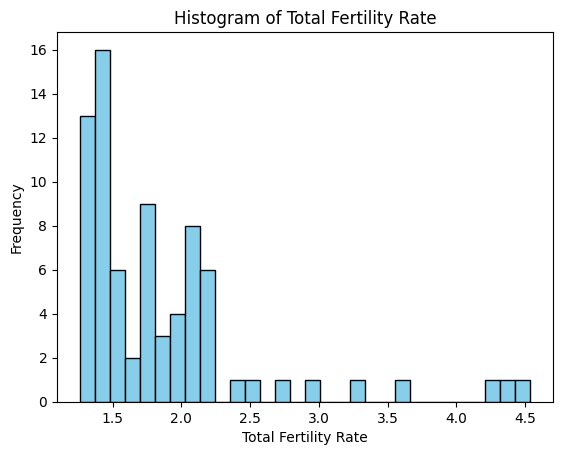

In [ ]:
import matplotlib.pyplot as plt

total_fertility_rate = df2['total_fertility_rate']

plt.hist(total_fertility_rate, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Total Fertility Rate')
plt.xlabel('Total Fertility Rate')
plt.ylabel('Frequency')
plt.show()

**Question 3:** : Create a different PyMC specification that IS appropriate for this new data column. \


In [ ]:
exponential_model = pm.Model()
with exponential_model:
    lam_parameter = pm.HalfNormal('rate_param')
    x_obs = pm.Exponential('fertility_obs', lam=lam_parameter, observed=total_fertility_rate)

/usr/local/lib/python3.10/dist-packages/pymc/model.py:1363: ImputationWarning: Data in fertility_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


**Question 4**: Provide posterior inference for the parameters of your new specification given the column of non-normal data using PyMC and provide an analysis of the MCMC chains.

Posterior inference for the Lambda parameter of exponential specification for "Total Fertility Rate" column of data. Since the histogram for the data shows a right skewness, an exponential distribution is an appropriate specification because it models variables in which small values occur more frequently than higher values (right skewness). \

The model is an exponential distribution with a half-normal prior on the rate parameter (lam_parameter). The likelihood is specified as an exponential distribution with observed data being the 'total_fertility_rate' column. \
The Gelman-Rubin statistics are used to assess convergence. Values close to 1 indicate convergence.

/usr/local/lib/python3.10/dist-packages/pymc/model.py:1363: ImputationWarning: Data in fertility_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


HMC Split-Rhats {'lam_parameter': 1.0008}


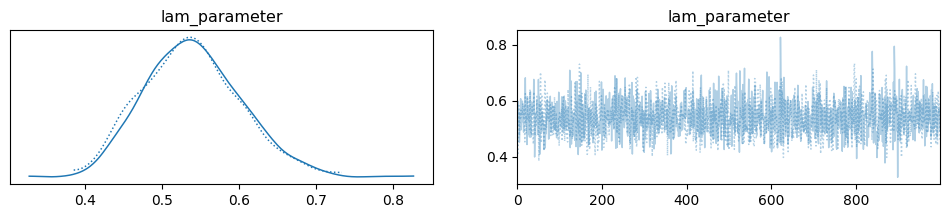

In [ ]:
total_fertility_rate = df2['total_fertility_rate']
exponential_model = pm.Model()
with exponential_model:
    lam_parameter = pm.HalfNormal('lam_parameter')
    x_obs = pm.Exponential('fertility_obs', lam=lam_parameter, observed=total_fertility_rate)
with exponential_model:
    fertility_data_HMC = pm.sample()

az.plot_trace(fertility_data_HMC, var_names=['lam_parameter'])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fertility_data_HMC).items() if 'lam_parameter' in k})

HMC sampling is performed to obtain posterior samples.

In [ ]:
n_mcmc_samples = 100
fig,ax = plt.subplots(2, 1, figsize=(14,6))
mcmc_chain = fertility_data_HMC.posterior["lam_parameter"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0].plot(mcmc_chain); ax[1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0].set_title("HMC");

Autocorrelation for HMC (MCMC) chain. Autocorrelation between consecutive samples in the MCMC chain is plotted.

Autocorrelation for HMC (MCMC) chain -0.08101165066861243


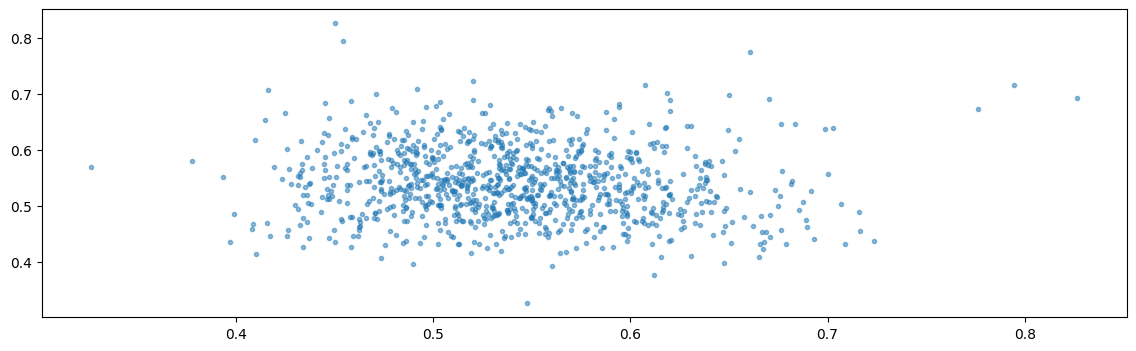

In [ ]:
max_mcmc_samples = 1000
fig,ax = plt.subplots(1, figsize=(14,4))
mcmc_chain = fertility_data_HMC.posterior["lam_parameter"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = fertility_data_HMC.posterior["lam_parameter"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

Bayesian Credible Interval for MCMC Bayesian Inference



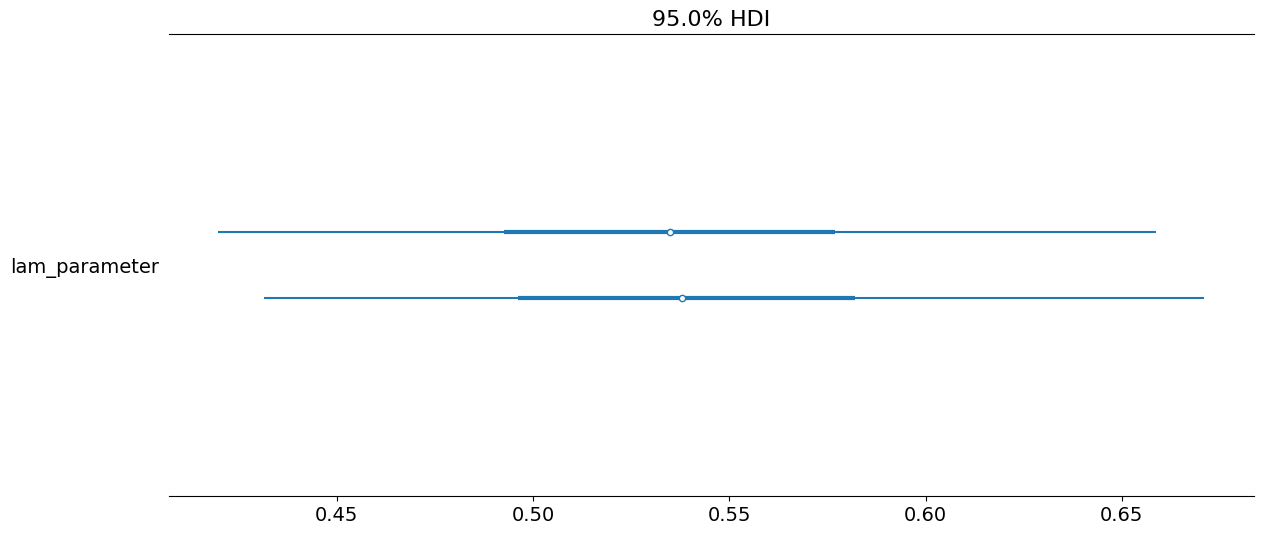

In [ ]:
fig,ax = plt.subplots(1, figsize=(14,6))
az.plot_forest(fertility_data_HMC, var_names=["lam_parameter"], combined=False, hdi_prob=0.95, ax = ax);